In [192]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
import random


In [193]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # or any integer you like

We ran the `chronos.sh` to get the embeddings first.

In [ ]:
# Load channel-wise patient embeddings
X_train = np.load("/cluster/scratch/gcardenal/chronos_embeddings_train_channelwise.npy")  # shape: (4000, 43, 512)
X_val   = np.load("/cluster/scratch/gcardenal/chronos_embeddings_val_channelwise.npy")
X_test  = np.load("/cluster/scratch/gcardenal/chronos_embeddings_test_channelwise.npy")

# Load binary outcome labels
y_train = np.load("y_train.npy")  # shape: (4000,)
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

In [195]:
# Convert data to PyTorch tensors
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)


In [196]:
class PatientClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128):
        super().__init__()
        self.attn_fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn_fc2 = nn.Linear(hidden_dim, 1)
        self.classifier = nn.Linear(input_dim, 1)

    def forward(self, x):  # x: (B, 43, 512)
        # Compute attention weights
        a = F.relu(self.attn_fc1(x))       # (B, 43, 128)
        a = self.attn_fc2(a).squeeze(-1)   # (B, 43)
        weights = F.softmax(a, dim=1)      # (B, 43)

        # Weighted sum over channels
        agg = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, 512)

        # Final prediction
        logit = self.classifier(agg)       # (B, 1)
        return torch.sigmoid(logit).squeeze(-1)  # (B,)

In [197]:
# Initialize model and training components
model = PatientClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Use BCEWithLogitsLoss instead of BCELoss
pos_weight = torch.tensor([6.22])  # or compute this dynamically
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_aurocs = []
val_aps = []

# Training loop
for epoch in range(55):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    
    # Validation performance
    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            preds = model(Xb).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(yb.numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_ap = average_precision_score(val_targets, val_preds)
        val_aurocs.append(val_auc)
        val_aps.append(val_ap)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    print(f"📊 Validation AUROC: {val_auc:.4f} | Avg Precision: {val_ap:.4f}")


Epoch 1 | Loss: 1.2427
📊 Validation AUROC: 0.5330 | Avg Precision: 0.1589
Epoch 2 | Loss: 1.2196
📊 Validation AUROC: 0.5113 | Avg Precision: 0.1539
Epoch 3 | Loss: 1.2091
📊 Validation AUROC: 0.5035 | Avg Precision: 0.1472
Epoch 4 | Loss: 1.2031
📊 Validation AUROC: 0.5018 | Avg Precision: 0.1455
Epoch 5 | Loss: 1.1990
📊 Validation AUROC: 0.5016 | Avg Precision: 0.1454
Epoch 6 | Loss: 1.1991
📊 Validation AUROC: 0.5014 | Avg Precision: 0.1448
Epoch 7 | Loss: 1.1957
📊 Validation AUROC: 0.5020 | Avg Precision: 0.1448
Epoch 8 | Loss: 1.1958
📊 Validation AUROC: 0.5022 | Avg Precision: 0.1448
Epoch 9 | Loss: 1.1978
📊 Validation AUROC: 0.5028 | Avg Precision: 0.1452
Epoch 10 | Loss: 1.1974
📊 Validation AUROC: 0.5034 | Avg Precision: 0.1454
Epoch 11 | Loss: 1.1964
📊 Validation AUROC: 0.5042 | Avg Precision: 0.1458
Epoch 12 | Loss: 1.1962
📊 Validation AUROC: 0.5051 | Avg Precision: 0.1461
Epoch 13 | Loss: 1.1952
📊 Validation AUROC: 0.5059 | Avg Precision: 0.1467
Epoch 14 | Loss: 1.1917
📊 Validati

In [198]:
epochs = np.arange(1, len(train_losses) + 1)

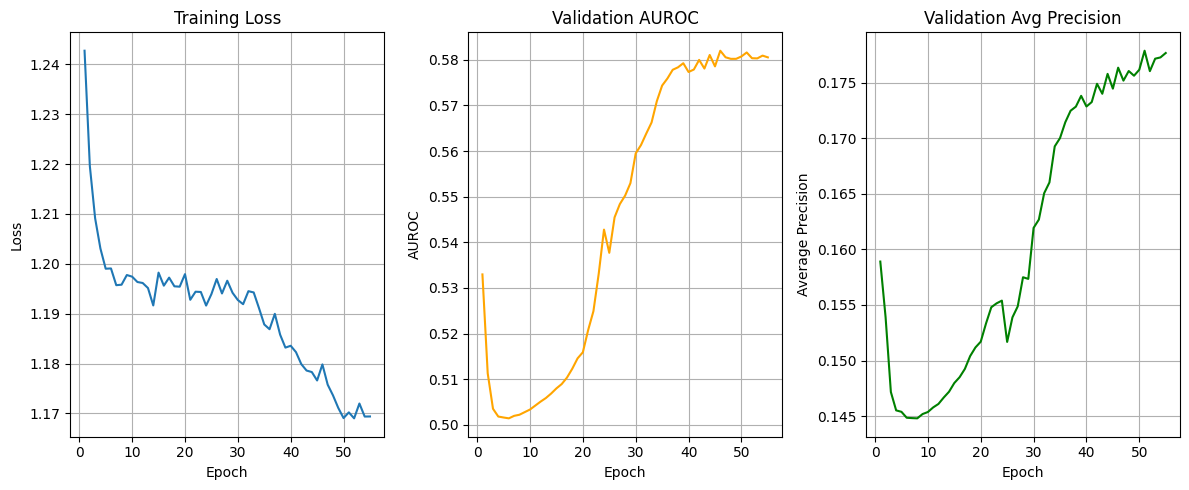

In [199]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_aurocs, label="Val AUROC", color="orange")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aps, label="Val AP", color="green")
plt.xlabel("Epoch")
plt.ylabel("Average Precision")
plt.title("Validation Avg Precision")
plt.grid()

plt.tight_layout()
plt.show()

In [200]:
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()
        test_preds.append(preds)
        test_targets.append(yb.numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# Compute metrics
test_auc = roc_auc_score(test_targets, test_preds)
test_ap = average_precision_score(test_targets, test_preds)

print(f"\n📊 Test AUROC: {test_auc:.4f}")
print(f"📊 Test Average Precision: {test_ap:.4f}")


📊 Test AUROC: 0.5862
📊 Test Average Precision: 0.1804


In [201]:
class PatientClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, dropout_prob=0.3):
        super().__init__()

        # Attention mechanism to compute channel weights
        self.attn_fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn_fc2 = nn.Linear(hidden_dim, 1)
        self.attn_dropout = nn.Dropout(dropout_prob)

        # Feature normalization
        self.norm = nn.LayerNorm(input_dim)

        # Classifier MLP head
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):  # x: (B, 43, 512)
        # Attention weights
        a = F.relu(self.attn_fc1(x))            # (B, 43, hidden_dim)
        a = self.attn_dropout(a)
        a = self.attn_fc2(a).squeeze(-1)        # (B, 43)
        weights = F.softmax(a, dim=1)           # (B, 43)

        # Weighted sum over channels
        agg = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, 512)

        # Normalize aggregated embedding
        agg = self.norm(agg)

        # Final prediction (logit output)
        logit = self.classifier(agg)  # (B, 1)
        return logit.squeeze(-1)      # No sigmoid (use BCEWithLogitsLoss)


In [202]:
 # Initialize model and training components
model = PatientClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Use BCEWithLogitsLoss instead of BCELoss
pos_weight = torch.tensor([6.22])  # or compute this dynamically
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_aurocs = []
val_aps = []

# Training loop
for epoch in range(55):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    
    # Validation performance
    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            preds = model(Xb).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(yb.numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_ap = average_precision_score(val_targets, val_preds)
        val_aurocs.append(val_auc)
        val_aps.append(val_ap)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    print(f"📊 Validation AUROC: {val_auc:.4f} | Avg Precision: {val_ap:.4f}")


Epoch 1 | Loss: 1.1872
📊 Validation AUROC: 0.6565 | Avg Precision: 0.2283
Epoch 2 | Loss: 1.1678
📊 Validation AUROC: 0.6621 | Avg Precision: 0.2332
Epoch 3 | Loss: 1.1603
📊 Validation AUROC: 0.6697 | Avg Precision: 0.2445
Epoch 4 | Loss: 1.1503
📊 Validation AUROC: 0.6714 | Avg Precision: 0.2469
Epoch 5 | Loss: 1.1435
📊 Validation AUROC: 0.6763 | Avg Precision: 0.2539
Epoch 6 | Loss: 1.1488
📊 Validation AUROC: 0.6795 | Avg Precision: 0.2588
Epoch 7 | Loss: 1.1512
📊 Validation AUROC: 0.6831 | Avg Precision: 0.2621
Epoch 8 | Loss: 1.1334
📊 Validation AUROC: 0.6860 | Avg Precision: 0.2658
Epoch 9 | Loss: 1.1313
📊 Validation AUROC: 0.6884 | Avg Precision: 0.2687
Epoch 10 | Loss: 1.1276
📊 Validation AUROC: 0.6904 | Avg Precision: 0.2713
Epoch 11 | Loss: 1.1189
📊 Validation AUROC: 0.6909 | Avg Precision: 0.2722
Epoch 12 | Loss: 1.1203
📊 Validation AUROC: 0.6944 | Avg Precision: 0.2755
Epoch 13 | Loss: 1.1127
📊 Validation AUROC: 0.6945 | Avg Precision: 0.2776
Epoch 14 | Loss: 1.1119
📊 Validati

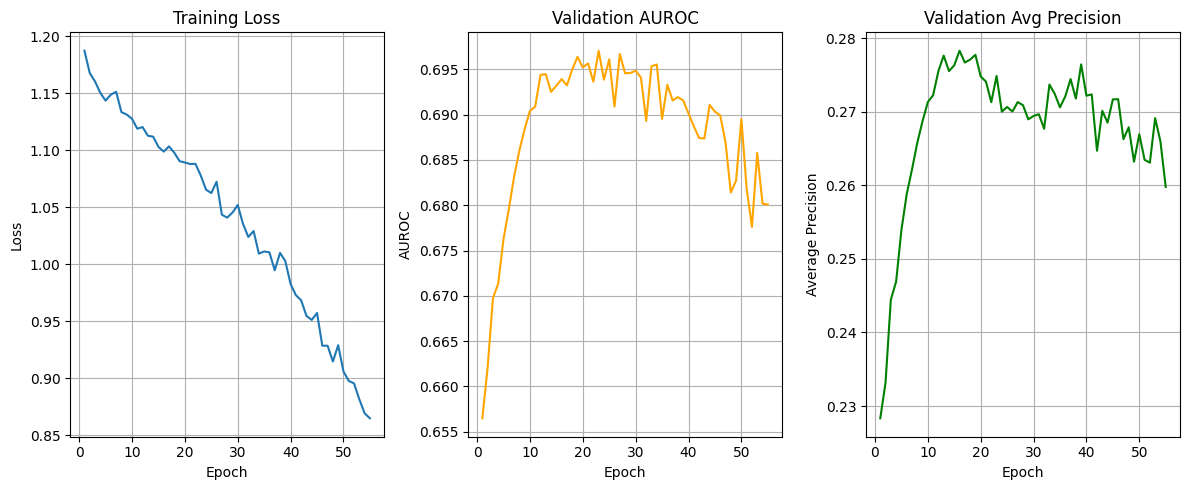

In [203]:
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_aurocs, label="Val AUROC", color="orange")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aps, label="Val AP", color="green")
plt.xlabel("Epoch")
plt.ylabel("Average Precision")
plt.title("Validation Avg Precision")
plt.grid()

plt.tight_layout()
plt.show()

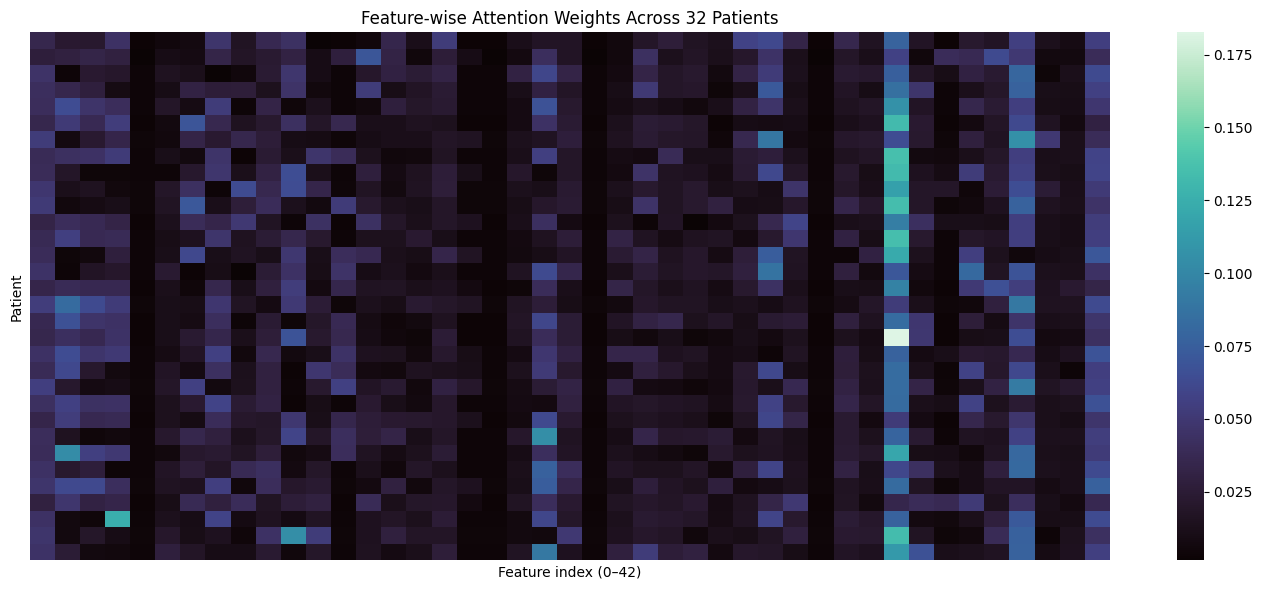

In [204]:
# Get attention weights for a batch of patients
with torch.no_grad():
    batch_X = torch.tensor(X_val[:32], dtype=torch.float32).to(device)  # shape: (32, 43, 512)
    a = F.relu(model.attn_fc1(batch_X))
    a = model.attn_fc2(a).squeeze(-1)
    attn_weights = F.softmax(a / 2.0, dim=1).cpu().numpy()  # shape: (32, 43)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(attn_weights, cmap="mako", xticklabels=False, yticklabels=False)
plt.title("Feature-wise Attention Weights Across 32 Patients")
plt.xlabel("Feature index (0–42)")
plt.ylabel("Patient")
plt.tight_layout()
plt.show()

In [205]:
class PatientClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, dropout_prob=0.3, temperature=2.0):
        super().__init__()
        self.temperature = temperature

        # Attention mechanism over 43 channels (features)
        self.attn_fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn_fc2 = nn.Linear(hidden_dim, 1)
        self.attn_dropout = nn.Dropout(dropout_prob)

        # Normalization layer for aggregated embedding
        self.norm = nn.LayerNorm(input_dim)

        # MLP classifier head
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, 1)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def forward(self, x):  # x: (batch_size, 43, 512)
        # Compute attention weights
        a = F.relu(self.attn_fc1(x))              # (B, 43, hidden)
        a = self.attn_dropout(a)
        a = self.attn_fc2(a).squeeze(-1)          # (B, 43)
        weights = F.softmax(a / self.temperature, dim=1)  # temperature-scaled softmax

        # Weighted sum of channel embeddings
        agg = torch.sum(x * weights.unsqueeze(-1), dim=1)  # (B, 512)
        agg = self.norm(agg)

        # Classifier prediction (logits)
        logit = self.classifier(agg)  # (B, 1)
        return logit.squeeze(-1)      # No sigmoid! (BCEWithLogitsLoss expects raw logits)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

In [206]:
# Initialize model and training components
model = PatientClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Use BCEWithLogitsLoss instead of BCELoss
pos_weight = torch.tensor([6.22])  # or compute this dynamically
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_aurocs = []
val_aps = []

# Training loop
for epoch in range(18):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    
    # Validation performance
    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            preds = model(Xb).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(yb.numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_auc = roc_auc_score(val_targets, val_preds)
        val_ap = average_precision_score(val_targets, val_preds)
        val_aurocs.append(val_auc)
        val_aps.append(val_ap)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    print(f"📊 Validation AUROC: {val_auc:.4f} | Avg Precision: {val_ap:.4f}")


Epoch 1 | Loss: 1.3031
📊 Validation AUROC: 0.6671 | Avg Precision: 0.2506
Epoch 2 | Loss: 1.1845
📊 Validation AUROC: 0.6613 | Avg Precision: 0.2372
Epoch 3 | Loss: 1.1571
📊 Validation AUROC: 0.6681 | Avg Precision: 0.2463
Epoch 4 | Loss: 1.1598
📊 Validation AUROC: 0.6752 | Avg Precision: 0.2563
Epoch 5 | Loss: 1.1470
📊 Validation AUROC: 0.6750 | Avg Precision: 0.2574
Epoch 6 | Loss: 1.1451
📊 Validation AUROC: 0.6770 | Avg Precision: 0.2618
Epoch 7 | Loss: 1.1395
📊 Validation AUROC: 0.6804 | Avg Precision: 0.2624
Epoch 8 | Loss: 1.1331
📊 Validation AUROC: 0.6835 | Avg Precision: 0.2680
Epoch 9 | Loss: 1.1261
📊 Validation AUROC: 0.6865 | Avg Precision: 0.2702
Epoch 10 | Loss: 1.1444
📊 Validation AUROC: 0.6882 | Avg Precision: 0.2707
Epoch 11 | Loss: 1.1242
📊 Validation AUROC: 0.6900 | Avg Precision: 0.2702
Epoch 12 | Loss: 1.1165
📊 Validation AUROC: 0.6945 | Avg Precision: 0.2796
Epoch 13 | Loss: 1.1105
📊 Validation AUROC: 0.6935 | Avg Precision: 0.2773
Epoch 14 | Loss: 1.1154
📊 Validati

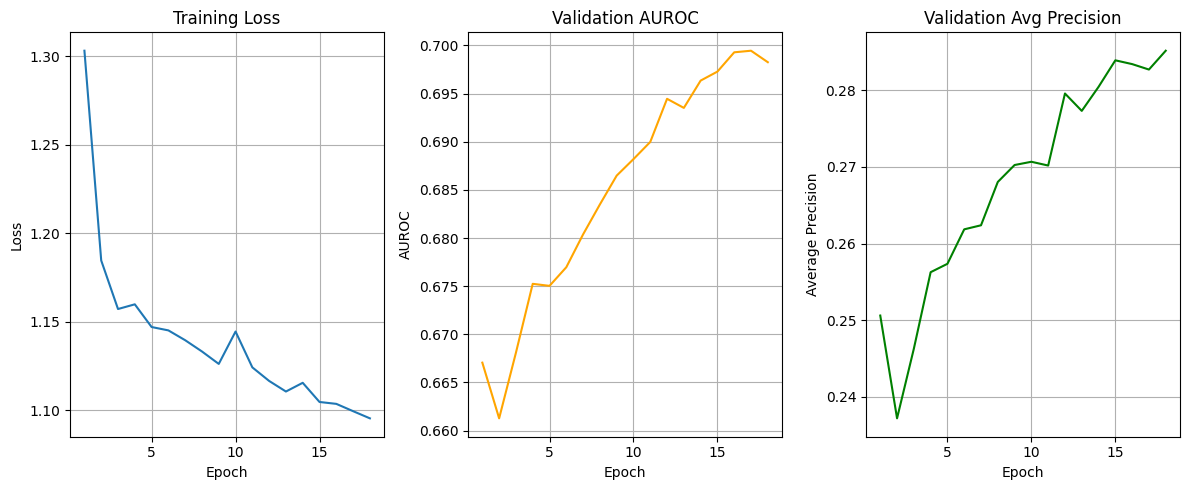

In [207]:
epochs = np.arange(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_aurocs, label="Val AUROC", color="orange")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aps, label="Val AP", color="green")
plt.xlabel("Epoch")
plt.ylabel("Average Precision")
plt.title("Validation Avg Precision")
plt.grid()

plt.tight_layout()
plt.show()

In [208]:
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()
        test_preds.append(preds)
        test_targets.append(yb.numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

# Compute metrics
test_auc = roc_auc_score(test_targets, test_preds)
test_ap = average_precision_score(test_targets, test_preds)

print(f"\n📊 Test AUROC: {test_auc:.4f}")
print(f"📊 Test Average Precision: {test_ap:.4f}")


📊 Test AUROC: 0.6833
📊 Test Average Precision: 0.2686


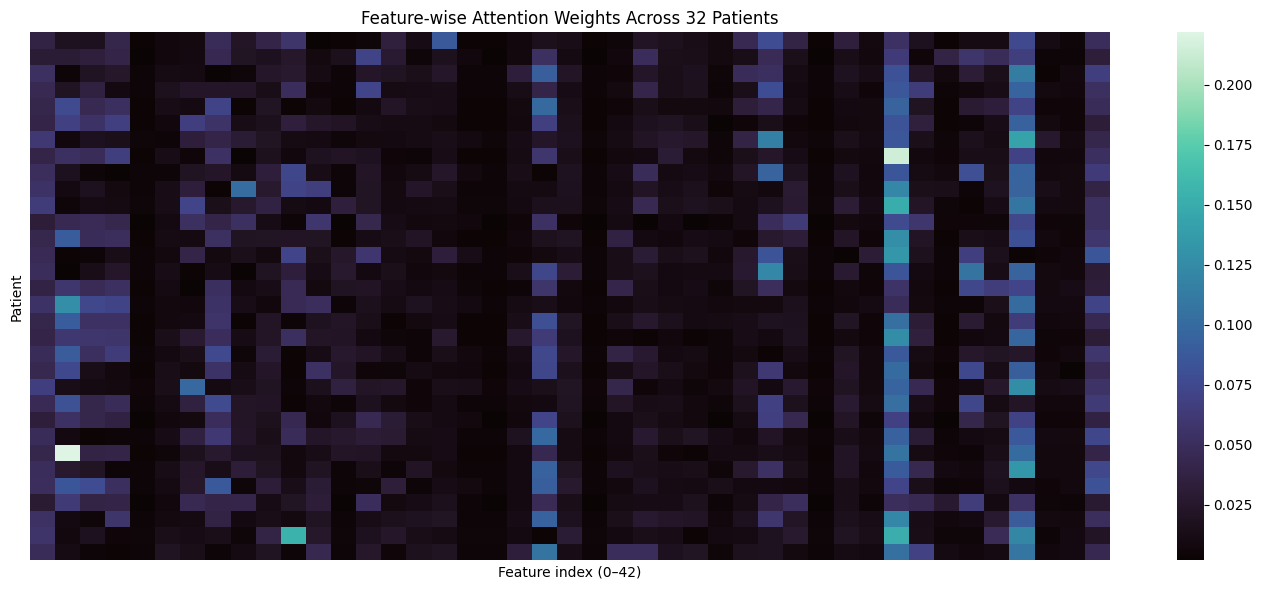

In [209]:
# Get attention weights for a batch of patients
with torch.no_grad():
    batch_X = torch.tensor(X_val[:32], dtype=torch.float32).to(device)  # shape: (32, 43, 512)
    a = F.relu(model.attn_fc1(batch_X))
    a = model.attn_fc2(a).squeeze(-1)
    attn_weights = F.softmax(a / 2.0, dim=1).cpu().numpy()  # shape: (32, 43)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(attn_weights, cmap="mako", xticklabels=False, yticklabels=False)
plt.title("Feature-wise Attention Weights Across 32 Patients")
plt.xlabel("Feature index (0–42)")
plt.ylabel("Patient")
plt.tight_layout()
plt.show()